# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from predprey_function import pred_prey

C:\Users\Ashok\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\Ashok\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


# Model Definition and Experiments


In [2]:
#Initiate Model
model = Model(name="PredPreyModel", function = pred_prey)

#Define Uncertainties
model.uncertainties = [RealParameter('prey_birth_rate', 0.015 , 0.035),
                       RealParameter('predation_rate', 0.0005 , 0.003),
                       RealParameter('predator_efficiency', 0.001 , 0.004),
                       RealParameter('predator_loss_rate', 0.04 , 0.08)]

#Define Outcomes
model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

#Turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 100

with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001279,0.003088,0.053335,0.034184,0,None,PredPreyModel
1,0.001700,0.001887,0.075465,0.027827,1,None,PredPreyModel
2,0.002200,0.003631,0.052336,0.018417,2,None,PredPreyModel
3,0.002734,0.003679,0.043374,0.025775,3,None,PredPreyModel
4,0.002343,0.003210,0.051512,0.031812,4,None,PredPreyModel
5,0.002228,0.002792,0.074186,0.032576,5,None,PredPreyModel
6,0.001057,0.002391,0.053038,0.019497,6,None,PredPreyModel
7,0.000939,0.001704,0.078657,0.028704,7,None,PredPreyModel
8,0.001507,0.002804,0.054655,0.030383,8,None,PredPreyModel
9,0.002314,0.002897,0.059195,0.016751,9,None,PredPreyModel


## Linear regression

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#create the right dataframe
prey = outcomes['prey']

#results = smf.ols('Lottery ~ Literacy + np.log(Pop1831)', data=dat).fit()


# SOBOL


In [6]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=500,
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)


#Si = sobol.analyze(problem, outcomes['predation_rate'],
                  # calc_second_order=True, print_to_console=False)
#Si = sobol.analyze(problem, outcomes['predator_efficiency'],
                 #  calc_second_order=True, print_to_console=False)
#Si = sobol.analyze(problem, outcomes['predator_loss_rate'],
                 #  calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5000 scenarios * 1 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
outcomes["prey"].shape

(5000, 1, 1461)

In [7]:
prey_mean = np.mean(outcomes['prey'][:,0,:], axis=1)

In [8]:
Si = sobol.analyze(problem, prey_mean,
                   calc_second_order=True, print_to_console=False)

In [9]:
import seaborn as sns

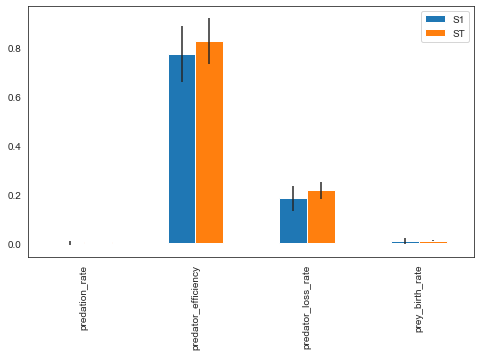

In [10]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()


# Extra Trees

In [26]:
indices["ST"]

predation_rate         0.005425
predator_efficiency    0.828010
predator_loss_rate     0.215999
prey_birth_rate        0.010643
Name: ST, dtype: float64

In [30]:
feature_scoring.get_feature_scores_all(x=indices['ST'], y= prey_mean, mode=feature_scoring.RuleInductionType.REGRESSION, max_features=0.6, nr_trees=100 )

AttributeError: 'numpy.ndarray' object has no attribute 'items'

In [22]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001049,0.001290,0.060742,0.028535,100,None,PredPreyModel
1,0.001201,0.001290,0.060742,0.028535,101,None,PredPreyModel
2,0.001049,0.003722,0.060742,0.028535,102,None,PredPreyModel
3,0.001049,0.001290,0.041836,0.028535,103,None,PredPreyModel
4,0.001049,0.001290,0.060742,0.032988,104,None,PredPreyModel
5,0.001049,0.003722,0.041836,0.032988,105,None,PredPreyModel
6,0.001201,0.001290,0.041836,0.032988,106,None,PredPreyModel
7,0.001201,0.003722,0.060742,0.032988,107,None,PredPreyModel
8,0.001201,0.003722,0.041836,0.028535,108,None,PredPreyModel
9,0.001201,0.003722,0.041836,0.032988,109,None,PredPreyModel
